# Deep learning Flow

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. 데이터 가져오기
TensorFlow에서 제공하는 MNIST 예제

- 데이터 shape, dtype 확인하기

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

In [5]:
print(train_x.shape)
print(train_x.dtype)
print(train_y.shape)
print(train_y.dtype)

(60000, 28, 28)
uint8
(60000,)
uint8


In [6]:
image = train_x[77]
image.shape

(28, 28)

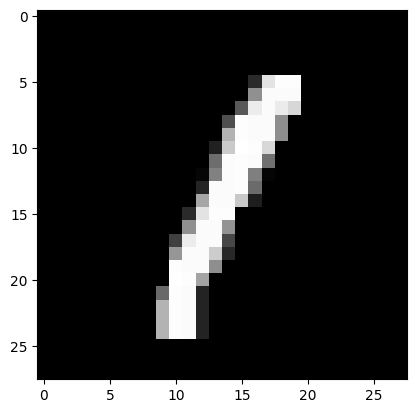

In [8]:
plt.imshow(image, 'gray')
plt.show()

In [9]:
y_unique, y_counts = np.unique(train_y, return_counts=True)

In [10]:
y_unique, y_counts

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

In [11]:
df_view = pd.DataFrame(data = {'count' : y_counts}, index = y_unique)

In [12]:
df_view.sort_values('count')

,count
5,5421
4,5842
8,5851
6,5918
0,5923
9,5949
2,5958
3,6131
7,6265
1,6742


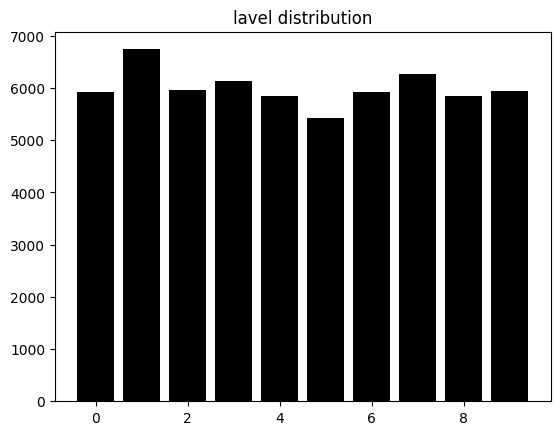

In [13]:
plt.bar(x=y_unique, height=y_counts, color='black')
plt.title('lavel distribution')
plt.show()

In [14]:
image = tf.constant(image)

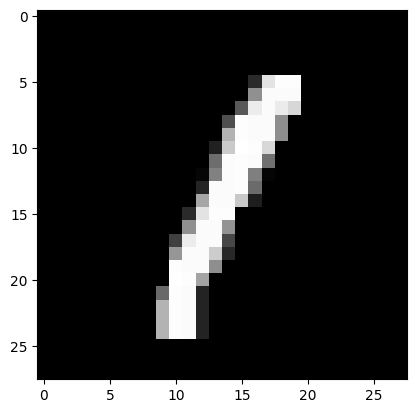

In [15]:
plt.imshow(image, 'gray')
plt.show()

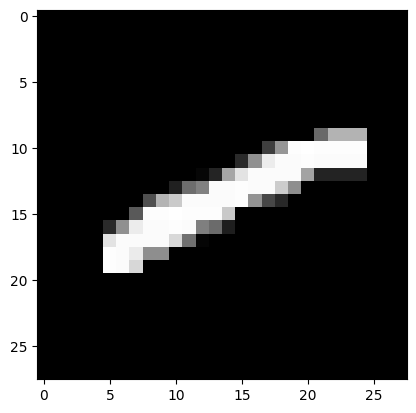

In [16]:
plt.imshow(tf.transpose(image),'gray')
plt.show()

### 2.Preprocessing

- 데이터 검증
- 전처리

#### 데이터 검증
- 데이터 중에 학습에 포함 되면 안되는 것이 있는가? ex> 개인정보가 들어있는 데이터, 테스트용 데이터에 들어있는것, 중복되는 데이터
- 학습 의도와 다른 데이터가 있는가? ex> 얼굴을 학습하는데 발 사진이 들어가있진 않은지(가끔은 의도하고 일부러 집어넣는 경우도 있음)
- 라벨이 잘못된 데이터가 있는가? ex> 7인데 1로 라벨링, 고양이인데 강아지로 라벨링

In [17]:
def validate_pixel_scale(x):
    return 255 >= x.max() and 0 <= x.min()

In [19]:
validated_train_x = np.array([x for x in train_x if validate_pixel_scale(x)])
validated_train_y = np.array([y for x, y in zip(train_x,train_y) if validate_pixel_scale(x)])

In [20]:
print(validated_train_x.shape)
print(validated_train_y.shape)

(60000, 28, 28)
(60000,)


In [21]:
train_y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

#### 전처리
- 입력하기 전에 모델링에 적합하게 처리!
- 대표적으로 Scaling, Resizing, label encoding 등
- dtype, shape 항상 체크!

##### Scaling

In [22]:
def scale(x):
    return (x / 255.0).astype(np.float32)

In [25]:
sample = scale(validated_train_x[777])

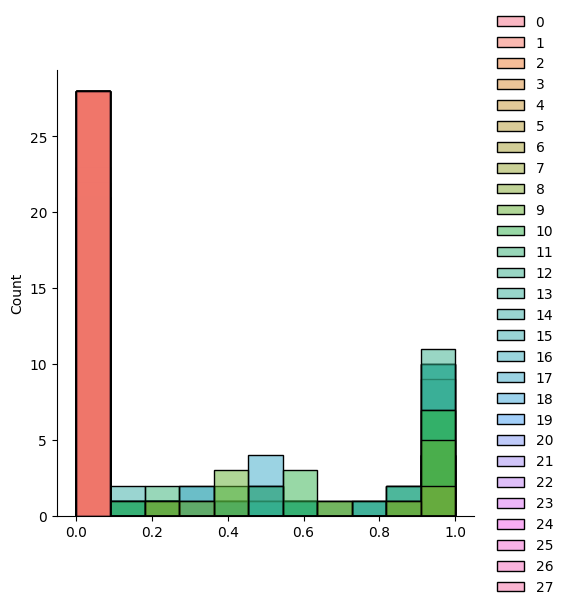

In [26]:
sns.displot(sample)

In [27]:
scaled_train_x = np.array([scale(x) for x in validated_train_x])

##### Flattening
- 이번에 사용할 모델은 기본적인 Feed-Forward Neural Network
- 1차원 벡터가 input의 샘플 하나가 된다.(2차원 텐서라는 말)

In [28]:
flattend_train_x = validated_train_x.reshape((60000,-1))

In [29]:
flattend_train_x.shape

(60000, 784)

##### Label encoding
- One-Hot encoding
- tf.keras.utils.to_categorical 사용!

In [23]:
tf.keras.utils.to_categorical(5, num_classes=10)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [30]:
ohe_train_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in validated_train_y] )

In [31]:
ohe_train_y.shape

(60000, 10)

### 보통은 큰 작업을 하나의 클래스로 만들어서 관리한다.

In [45]:
class DataLoader():
    
    def __init__(self):
        (self.train_x, self.train_y),(self.test_x, self.test_y) = tf.keras.datasets.mnist.load_data()
        
    def validate_pixel_scale(self, x):
        return 255 >= x.max() and 0 <= x.min()
    
    def scale(self, x):
        return (x / 255.0).astype(np.float32)
    
    def preprocess_dataset(self, dataset):
        feature, target = dataset
        
        validated_x = np.array([x for x in feature if self.validate_pixel_scale(x)])
        validated_y = np.array([y for x, y in zip(feature, target) if self.validate_pixel_scale(x)])
        
        # scale
        scaled_x = np.array([self.scale(x) for x in validated_x])
        # flatten
        flatten_x = scaled_x.reshape((scaled_x.shape[0],-1))
        # label encoding
        ohe_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in validated_y])
        
        return flatten_x, ohe_y
    
    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))
    
    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

In [46]:
mnist_loader = DataLoader()

In [47]:
train_x, train_y = mnist_loader.get_train_dataset()

In [48]:
test_x, test_y = mnist_loader.get_train_dataset()

In [50]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(60000, 784)
(60000, 784)
(60000, 10)
(60000, 10)


### 3. Modeling
1. 모델 정의
2. 학습 로직 - 비용함수, 학습파라미터 세팅
3. 학습

#### 모델 정의

In [52]:
from tensorflow.keras.layers import Dense, Activation

In [54]:
model = tf.keras.Sequential()

In [55]:
model.add(Dense(15, input_dim = 784))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                11775     
                                                                 
 activation (Activation)     (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


#### 학습 로직

In [57]:
opt = tf.keras.optimizers.SGD(0.03)
loss = tf.keras.losses.categorical_crossentropy

In [58]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

#### 학습 실행

In [60]:
model.fit(train_x, train_y, epochs=10, batch_size=256)

Epoch 1/10
235/235 [==============================] - 1s 2ms/step - loss: 2.1084 - accuracy: 0.4257
Epoch 2/10
235/235 [==============================] - 0s 2ms/step - loss: 1.7018 - accuracy: 0.6504
Epoch 3/10
235/235 [==============================] - 0s 2ms/step - loss: 1.4057 - accuracy: 0.7046
Epoch 4/10
235/235 [==============================] - 1s 2ms/step - loss: 1.1878 - accuracy: 0.7518
Epoch 5/10
235/235 [==============================] - 0s 2ms/step - loss: 1.0277 - accuracy: 0.7839
Epoch 6/10
235/235 [==============================] - 0s 2ms/step - loss: 0.9087 - accuracy: 0.8086
Epoch 7/10
235/235 [==============================] - 0s 2ms/step - loss: 0.8186 - accuracy: 0.8264
Epoch 8/10
235/235 [==============================] - 0s 2ms/step - loss: 0.7484 - accuracy: 0.8401
Epoch 9/10
235/235 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.8505
Epoch 10/10
235/235 [==============================] - 0s 2ms/step - loss: 0.6468 - accuracy: 0.8593

In [61]:
hist = model.fit(train_x, train_y, epochs=10, batch_size=256)

Epoch 1/10
235/235 [==============================] - 0s 2ms/step - loss: 0.6087 - accuracy: 0.8660
Epoch 2/10
235/235 [==============================] - 0s 2ms/step - loss: 0.5767 - accuracy: 0.8716
Epoch 3/10
235/235 [==============================] - 0s 2ms/step - loss: 0.5493 - accuracy: 0.8756
Epoch 4/10
235/235 [==============================] - 0s 2ms/step - loss: 0.5256 - accuracy: 0.8792
Epoch 5/10
235/235 [==============================] - 0s 2ms/step - loss: 0.5050 - accuracy: 0.8825
Epoch 6/10
235/235 [==============================] - 0s 2ms/step - loss: 0.4871 - accuracy: 0.8846
Epoch 7/10
235/235 [==============================] - 0s 2ms/step - loss: 0.4712 - accuracy: 0.8871
Epoch 8/10
235/235 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.8891
Epoch 9/10
235/235 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.8917
Epoch 10/10
235/235 [==============================] - 0s 2ms/step - loss: 0.4332 - accuracy: 0.8931

In [62]:
hist.history

{'loss': [0.6087270975112915,
  0.5766779780387878,
  0.5492614507675171,
  0.5256209373474121,
  0.5050353407859802,
  0.48705989122390747,
  0.4711849093437195,
  0.45705142617225647,
  0.4444826543331146,
  0.43317723274230957],
 'accuracy': [0.8660333156585693,
  0.8716333508491516,
  0.8755833506584167,
  0.8791833519935608,
  0.8825166821479797,
  0.8846333622932434,
  0.8870833516120911,
  0.8891333341598511,
  0.8916666507720947,
  0.8931333422660828]}

### 4. Evaluation
- 학습 과정 추적
- Test / 모델 검증
- 후처리

##### 학습 과정 추적

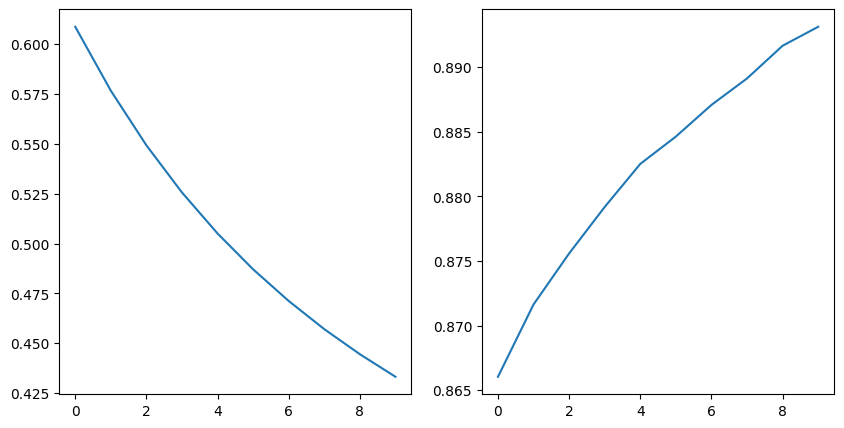

In [64]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(hist.history['loss'])

plt.subplot(122)
plt.plot(hist.history['accuracy'])

plt.show()

##### 모델 검증

In [66]:
model.evaluate(test_x,test_y)

1875/1875 [==============================] - 3s 1ms/step - loss: 0.4276 - accuracy: 0.8939


[0.42757347226142883, 0.8939499855041504]

##### 후처리

In [69]:
pred = model.predict(test_x[:1])

In [70]:
pred.argmax()

5

In [71]:
sample_img = test_x[0].reshape((28, 28)) * 255

In [73]:
test_y[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

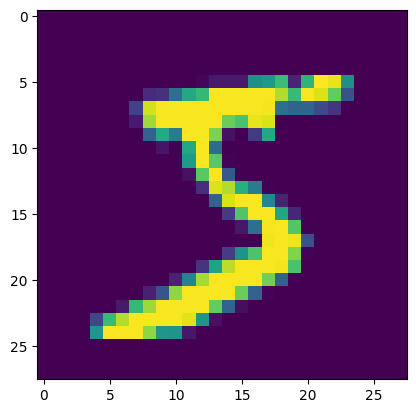

In [72]:
plt.imshow(sample_img)
plt.show()